In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
data = pd.read_csv("/home/ram/Desktop/GSpann/test_data_RF.csv")

In [3]:
data.head()

,agentID,age,education,Location,years_mem,sub_members,commitment,returned_orders,compn_prev,compn_curr
0,1,42,lower,SF,7,12,F,369,819,731.073989
1,2,28,medium,WA,3,13,F,136,377,755.629417
2,3,45,higher,DE,6,2,F,38,203,545.505775
3,4,33,lower,TX,10,6,P,31,31,456.367827
4,5,32,higher,TX,9,20,P,173,398,813.790778


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 10 columns):
agentID            50 non-null int64
age                50 non-null int64
education          50 non-null object
Location           50 non-null object
years_mem          50 non-null int64
sub_members        50 non-null int64
commitment         50 non-null object
returned_orders    50 non-null int64
compn_prev         50 non-null int64
compn_curr         50 non-null float64
dtypes: float64(1), int64(6), object(3)
memory usage: 4.0+ KB


In [5]:
data_new = data[["education", "Location", "commitment"]].apply(LabelEncoder().fit_transform)
data_new.head()

,education,Location,commitment
0,1,1,0
1,2,3,0
2,0,0,0
3,1,2,1
4,0,2,1


In [6]:
data["education"] = data_new["education"]
data["Location"] = data_new["Location"]
data["commitment"] = data_new["commitment"]
data.head()

,agentID,age,education,Location,years_mem,sub_members,commitment,returned_orders,compn_prev,compn_curr
0,1,42,1,1,7,12,0,369,819,731.073989
1,2,28,2,3,3,13,0,136,377,755.629417
2,3,45,0,0,6,2,0,38,203,545.505775
3,4,33,1,2,10,6,1,31,31,456.367827
4,5,32,0,2,9,20,1,173,398,813.790778


In [7]:
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,:-1], data["compn_curr"],
                            test_size=0.2, random_state=23)

In [8]:
X_train.head()

,agentID,age,education,Location,years_mem,sub_members,commitment,returned_orders,compn_prev
29,30,45,2,1,1,17,1,89,411
10,11,28,0,2,3,11,1,27,583
44,45,44,0,3,10,18,0,201,949
3,4,33,1,2,10,6,1,31,31
22,23,30,0,2,0,12,0,28,798


In [9]:
print (X_train.dtypes)
X_train.shape

agentID            int64
age                int64
education          int64
Location           int64
years_mem          int64
sub_members        int64
commitment         int64
returned_orders    int64
compn_prev         int64
dtype: object


(40, 9)

In [10]:
print (y_train.head())
y_train.shape

29     730.769042
10     758.242303
44    1085.001018
3      456.367827
22     975.561658
Name: compn_curr, dtype: float64


(40,)

## Linear Regression:

In [11]:
Lin_reg = linear_model.LinearRegression()

In [12]:
Lin_reg.fit(X_train, y_train)
y_pred_lin = Lin_reg.predict(X_test)

In [13]:
y_pred_lin

array([ 937.35568263,  262.17396119,  703.01281661,  360.62795399,
        556.19240857,  410.45028235,  240.54292621,  503.67194865,
        986.94957793,  712.38585933])

In [14]:
y_test

14    932.735136
18    267.225682
17    703.138720
32    344.402816
13    560.854223
33    407.241700
20    218.866195
8     457.586380
36    989.519334
28    723.752545
Name: compn_curr, dtype: float64

In [15]:
from sklearn.metrics import r2_score

In [16]:
r2_score_lin = r2_score(y_test, y_pred_lin)
print ("R^2 score of Linear Regression:", r2_score_lin)

R^2 score of Linear Regression: 0.995296793372


## Simple Random Forest Regressor

In [17]:
from sklearn.ensemble import RandomForestRegressor

In [18]:
Rdm_reg = RandomForestRegressor(random_state=1, oob_score = True)

Rdm_reg.fit(X_train, y_train)
y_pred_rdm = Rdm_reg.predict(X_test)

/home/ram/miniconda2/envs/greyatom/lib/python2.7/site-packages/sklearn/ensemble/forest.py:720: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


In [19]:
y_pred_rdm

array([ 793.07519269,  354.54867386,  656.46347469,  383.56579516,
        664.82858353,  458.13983538,  340.93437485,  706.26883439,
        872.20339341,  682.55919011])

In [20]:
r2_score_rdm = r2_score(y_test, y_pred_rdm)
print ("R^2 score of Random Forest Regressor:", r2_score_rdm)

R^2 score of Random Forest Regressor: 0.79108212138


## Parameter Tuned Random Forest Regressor

In [21]:
parameters = {'n_estimators': [4, 6, 9, 15, 20], 
              'max_features': ['log2', 'sqrt','auto'], 
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8]
             }

In [22]:
from sklearn.model_selection import GridSearchCV

In [23]:
def plot_train_test_scores(grid_obj):    
    
    test_score = grid_obj.cv_results_['mean_test_score']
    train_score = grid_obj.cv_results_['mean_train_score']
    
    labels = map(str, grid_obj.param_grid.values()[0])
    x = np.arange(1, len(labels)+1)
    sns.set_style('darkgrid')
    
    plt.figure(figsize=(10,6))
    plt.plot(x, test_score, c='purple')
    plt.plot(x, train_score, c='green')
    plt.xlabel(grid_obj.param_grid.keys()[0])
    plt.xticks(x, labels)
    plt.show()

In [24]:
def Random_Forest_Regressor(reg, parameters, x, y):
    
    grid_obj = GridSearchCV(reg, parameters)
    grid_obj = grid_obj.fit(x, y)
    
    reg_grid_obj = grid_obj.best_estimator_
    y_pred_rfr = reg_grid_obj.predict(X_test)
    
    plot_train_test_scores(grid_obj)
    
    return r2_score(y_test, y_pred_rfr), grid_obj.best_params_

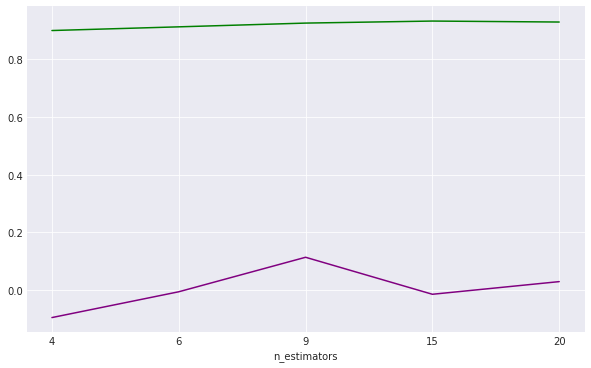

0.802269420098
{u'n_estimators': 9}


In [25]:
score, para_n_estimators = Random_Forest_Regressor(Rdm_reg, {'n_estimators': [4, 6, 9, 15, 20]}, X_train, y_train)
print (score)
print (para_n_estimators)

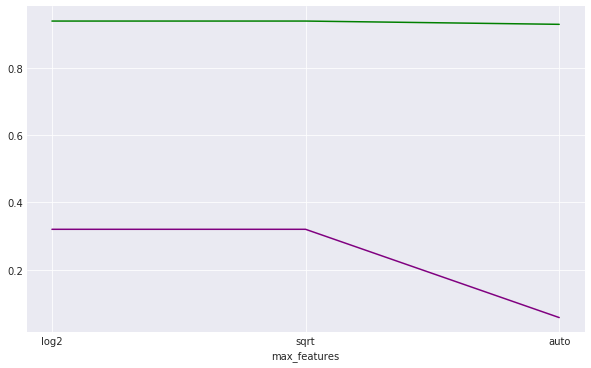

0.812879292027
{u'max_features': u'log2'}


In [26]:
score, para_max_features = Random_Forest_Regressor(Rdm_reg, {'max_features': ['log2', 'sqrt','auto']}, X_train, y_train)
print (score)
print (para_max_features)

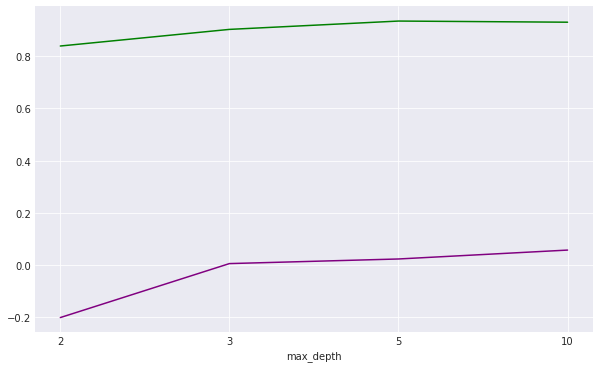

0.79108212138
{u'max_depth': 10}


In [27]:
score, para_max_depth = Random_Forest_Regressor(Rdm_reg, {'max_depth': [2, 3, 5, 10]}, X_train, y_train)
print (score)
print (para_max_depth)

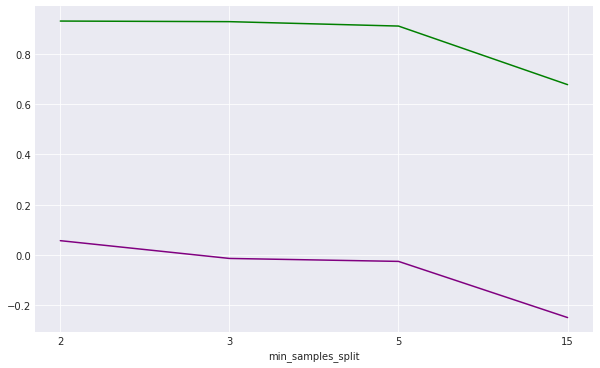

0.79108212138
{u'min_samples_split': 2}


In [28]:
score, para_min_samples_split = Random_Forest_Regressor(Rdm_reg, {'min_samples_split': [2, 3, 5, 15]}, X_train, y_train)
print (score)
print (para_min_samples_split)

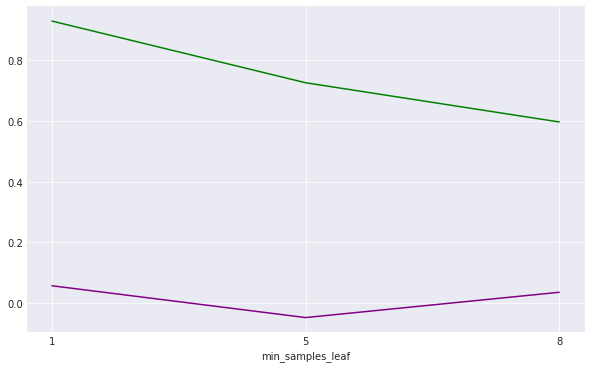

0.79108212138
{u'min_samples_leaf': 1}


In [29]:
score, para_min_samples_leaf = Random_Forest_Regressor(Rdm_reg, {'min_samples_leaf': [1,5,8]}, X_train, y_train)
print (score)
print (para_min_samples_leaf)

## Random Forest: Taking the best Parameters

In [30]:
Rdm_reg = RandomForestRegressor(n_estimators= para_n_estimators.values()[0],
                                max_features= para_max_features.values()[0], 
                                max_depth= para_max_depth.values()[0],
                                min_samples_split= para_min_samples_split.values()[0],
                                min_samples_leaf= para_min_samples_leaf.values()[0],
                                random_state=1, oob_score = True)

Rdm_reg.fit(X_train, y_train)
y_pred_rdm = Rdm_reg.predict(X_test)

In [31]:
r2_score_rdm = r2_score(y_test, y_pred_rdm)
print ("R^2 score of Random Forest Regressor:", r2_score_rdm)

R^2 score of Random Forest Regressor: 0.827057885377


Sores:

* Linear regression: 0.995296793372

* Random Forest Regressor: 0.827057885377

As Expected:
Linear regression performs better than Random Forest Regressor